# Group 9
- Zhixin Zeng
- Yichen Wang
- Mingyi Ni
- Zixiang Hu

## Thesis: Greater access to the internet leads to higher economic growth.

### Data used:
1. Individuals using the Internet (% of population) [link](https://data.worldbank.org/indicator/IT.NET.USER.ZS)
2. GDP growth (annual %) [link](https://data.worldbank.org/indicator/NY.GDP.MKTP.KD.ZG)


In [1]:
!pip install pymongo
!pip install geopandas

Looking in indexes: https://pypi.python.org/simple/
Looking in indexes: https://pypi.python.org/simple/


# Connect DB

In [2]:
username="crimson725"
password="13678422587"
cluster_address="cluster0.1nh21id.mongodb.net"
uri = f"mongodb+srv://{username}:{password}@{cluster_address}/?retryWrites=true&w=majority&appName=Cluster0"

In [3]:
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi

client = MongoClient(uri, server_api=ServerApi('1'))

try:
    client.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(e)

Pinged your deployment. You successfully connected to MongoDB!


In [4]:
db=client['Proj3']
# The two collections are 'gdp_growth' and 'internet_penetration_rates'

In [ ]:
# Import the libs for data analytics
import pandas as pd
from pprint import pprint
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Import the data

In [5]:
gdp_growth = pd.read_csv('gdp_growth.csv')
internet_penetration_rates = pd.read_csv('Individuals_using_internet.csv')

if "gdp_growth" in db.list_collection_names():
    db.drop_collection('gdp_growth')
if "internet_penetration_rates" in db.list_collection_names():
    db.drop_collection('internet_penetration_rates')

gdp_collection=db['gdp_growth']
internet_collection=db['internet_penetration_rates']
gdp_growth.fillna(0, inplace=True)
internet_penetration_rates.fillna(0, inplace=True)


In [6]:
# Do some conversion
gdp_growth['Country Name'] = gdp_growth['Country Name'].astype(str)
gdp_growth['Country Code'] = gdp_growth['Country Code'].astype(str)
gdp_growth['Indicator Name'] = gdp_growth['Indicator Name'].astype(str)
internet_penetration_rates['Country Name'] = internet_penetration_rates['Country Name'].astype(str)
internet_penetration_rates['Country Code'] = internet_penetration_rates['Country Code'].astype(str)
internet_penetration_rates['Indicator Name'] = internet_penetration_rates['Indicator Name'].astype(str)


In [7]:
# Import into MongoDB
gdp_collection.insert_many(gdp_growth.to_dict('records'))
internet_collection.insert_many(internet_penetration_rates.to_dict('records'))

InsertManyResult([ObjectId('662863e21317ae045fe80f47'), ObjectId('662863e21317ae045fe80f48'), ObjectId('662863e21317ae045fe80f49'), ObjectId('662863e21317ae045fe80f4a'), ObjectId('662863e21317ae045fe80f4b'), ObjectId('662863e21317ae045fe80f4c'), ObjectId('662863e21317ae045fe80f4d'), ObjectId('662863e21317ae045fe80f4e'), ObjectId('662863e21317ae045fe80f4f'), ObjectId('662863e21317ae045fe80f50'), ObjectId('662863e21317ae045fe80f51'), ObjectId('662863e21317ae045fe80f52'), ObjectId('662863e21317ae045fe80f53'), ObjectId('662863e21317ae045fe80f54'), ObjectId('662863e21317ae045fe80f55'), ObjectId('662863e21317ae045fe80f56'), ObjectId('662863e21317ae045fe80f57'), ObjectId('662863e21317ae045fe80f58'), ObjectId('662863e21317ae045fe80f59'), ObjectId('662863e21317ae045fe80f5a'), ObjectId('662863e21317ae045fe80f5b'), ObjectId('662863e21317ae045fe80f5c'), ObjectId('662863e21317ae045fe80f5d'), ObjectId('662863e21317ae045fe80f5e'), ObjectId('662863e21317ae045fe80f5f'), ObjectId('662863e21317ae045fe80f

# Inspect the data

In [8]:
pprint(db.gdp_growth.find_one())  
pprint(db.internet_penetration_rates.find_one())  

{'1960': 0.0,
 '1961': 0.0,
 '1962': 0.0,
 '1963': 0.0,
 '1964': 0.0,
 '1965': 0.0,
 '1966': 0.0,
 '1967': 0.0,
 '1968': 0.0,
 '1969': 0.0,
 '1970': 0.0,
 '1971': 0.0,
 '1972': 0.0,
 '1973': 0.0,
 '1974': 0.0,
 '1975': 0.0,
 '1976': 0.0,
 '1977': 0.0,
 '1978': 0.0,
 '1979': 0.0,
 '1980': 0.0,
 '1981': 0.0,
 '1982': 0.0,
 '1983': 0.0,
 '1984': 0.0,
 '1985': 0.0,
 '1986': 0.0,
 '1987': 16.07843137,
 '1988': 18.64864865,
 '1989': 12.12984055,
 '1990': 3.961401727,
 '1991': 7.962871744,
 '1992': 5.882353953,
 '1993': 7.307693245,
 '1994': 8.203901293,
 '1995': 2.547143687,
 '1996': 1.185788511,
 '1997': 7.046874992,
 '1998': 1.991984449,
 '1999': 1.238041842,
 '2000': 7.622920639,
 '2001': 4.182002641,
 '2002': -0.944954681,
 '2003': 1.11050501,
 '2004': 7.29372894,
 '2005': -0.383139604,
 '2006': 1.127412128,
 '2007': 3.089543901,
 '2008': 1.835755679,
 '2009': -11.67774203,
 '2010': -2.733455707,
 '2011': 3.369238122,
 '2012': -1.040800135,
 '2013': 6.431481824,
 '2014': -1.586574644,
 '

# Check if there is missing data

In [9]:
# Count documents with missing 'Country Code' in the 'gdp_growth' collection
missing_country_gdp_count = db.gdp_growth.count_documents({"$or": [{"Country Code": {"$exists": False}}, {"Country Code": None}]})
missing_country_internet_count = db.internet_penetration_rates.count_documents({"$or": [{"Country Code": {"$exists": False}}, {"Country Code": None}]})

print("Missing country codes in GDP Growth:", missing_country_gdp_count)
print("Missing country codes in Internet Penetration:", missing_country_internet_count)

Missing country codes in GDP Growth: 0
Missing country codes in Internet Penetration: 0


# Handling Zeroes for Internet Penetration Rate

In [10]:
pipeline = [
    {
        "$project": {
            "data": {
                "$objectToArray": "$$ROOT"
            }
        }
    },
    {
        "$unwind": "$data"
    },
    {
        "$match": {
            "data.k": {
                "$regex": "^\d{4}$"
            }
        }
    },
    {
        "$addFields": {
            "data.v": {
                "$cond": [
                    {"$eq": ["$data.v", 0]}, 
                    "$$REMOVE", 
                    "$data.v"
                ]
            }
        }
    },
    {
        "$group": {
            "_id": "$data.k",
            "values": {
                "$push": "$data.v"
            }
        }
    },
    {
        "$addFields": {
            "count": {"$size": "$values"},
            "midIndex": {"$floor": {"$divide": [{"$size": "$values"}, 2]}}
        }
    },
    {
        "$addFields": {
            "valuesSorted": {"$sortArray": {"input": "$values", "sortBy": {"$const": 1}}}
        }
    },
    {
        "$addFields": {
            "median": {
                "$cond": {
                    "if": {"$eq": [{"$mod": ["$count", 2]}, 0]},
                    "then": {
                        "$avg": [
                            {"$arrayElemAt": ["$valuesSorted", "$midIndex"]},
                            {"$arrayElemAt": ["$valuesSorted", {"$subtract": ["$midIndex", 1]}]}
                        ]
                    },
                    "else": {
                        "$arrayElemAt": ["$valuesSorted", "$midIndex"]
                    }
                }
            }
        }
    },
    {
        "$project": {
            "medianRate": "$median"
        }
    }
]

# Execute the aggregation pipeline
yearly_medians = list(db.internet_penetration_rates.aggregate(pipeline))
yearly_medians_dict = {item['_id']: item['medianRate'] for item in yearly_medians}

In [11]:
# Insert the calculated data
for year,median_value in yearly_medians_dict.items():
    update_result = db.internet_penetration_rates.update_many(
        {year: {"$eq": 0}},
        {"$set": {year: median_value}}
    )

# Handling zeroes for GDP growth

In [12]:
pipeline = [
    {
        "$project": {
            "Country Code": 1,
            "data": {"$objectToArray": "$$ROOT"}
        }
    },
    {
        "$unwind": "$data"
    },
    {
        "$match": {
            "data.k": {"$regex": "^\d{4}$"}
        }
    },
    {
        "$group": {
            "_id": "$data.k",
            "values": {"$push": "$data.v"}
        }
    },
    {
        "$addFields": {
            "count": {"$size": "$values"},
            "midIndex": {"$floor": {"$divide": [{"$size": "$values"}, 2]}}
        }
    },
    {
        "$addFields": {
            "valuesSorted": {"$sortArray": {"input": "$values", "sortBy": {"$const": 1}}}
        }
    },
    {
        "$addFields": {
            "median": {
                "$cond": {
                    "if": {"$eq": [{"$mod": ["$count", 2]}, 0]},  # Check if count is even
                    "then": {  # If even, average middle two values
                        "$avg": [
                            {"$arrayElemAt": ["$valuesSorted", "$midIndex"]},
                            {"$arrayElemAt": ["$valuesSorted", {"$subtract": ["$midIndex", 1]}]}
                        ]
                    },
                    "else": {  # If odd, take the middle value
                        "$arrayElemAt": ["$valuesSorted", "$midIndex"]
                    }
                }
            }
        }
    },
    {
        "$project": {
            "medianGDP": "$median"
        }
    },
    {
        "$sort": {"_id": 1}
    }
]

# Execute the aggregation pipeline
yearly_medians = list(db.gdp_growth.aggregate(pipeline))
yearly_medians_dict = {item['_id']: item['medianGDP'] for item in yearly_medians}

In [13]:
# Update the missing data
for year, median in yearly_medians_dict.items():
    query = {year: 0}
    update = {"$set": {year: median}}
    db.gdp_growth.update_many(query, update)

# Regression and Correlation Analysis

In [14]:
# Preparing dataframe
internet_data = list(db.internet_penetration_rates.find())
gdp_data = list(db.gdp_growth.find())
df_internet = pd.DataFrame(internet_data)
df_gdp = pd.DataFrame(gdp_data)

df_internet_melted = df_internet.melt(
    id_vars=["Country Name", "Country Code", "_id"],
    var_name="Year",
    value_name="Internet Penetration Rate",
)
df_gdp_melted = df_gdp.melt(
    id_vars=["Country Name", "Country Code", "_id"],
    var_name="Year",
    value_name="GDP Growth",
)
df_internet_melted["Year"] = pd.to_numeric(df_internet_melted["Year"], errors="coerce")
df_gdp_melted["Year"] = pd.to_numeric(df_gdp_melted["Year"], errors="coerce")

df_merged = pd.merge(
    df_internet_melted, df_gdp_melted, on=["Country Code", "Year"], suffixes=("", "_y")
)
df_merged.drop(columns=["Country Name_y", "_id_y"], inplace=True)
df_merged.rename(columns=lambda x: x.replace("_x", ""), inplace=True)
df_merged["Year"] = pd.to_numeric(df_merged["Year"], errors="coerce").astype(
    pd.Int32Dtype()
)
df_merged.dropna(inplace=True)

In [27]:
correlation_results = pd.DataFrame(columns=['Country', 'Correlation Coefficient'])
for country in df_merged['Country Name'].unique():
    country_data = df_merged[df_merged['Country Name'] == country]
    correlation = country_data['Internet Penetration Rate'].corr(country_data['GDP Growth'])
    new_row = pd.DataFrame({
        'Country': [country],
        'Correlation Coefficient': [correlation]
    })
    correlation_results = pd.concat([correlation_results, new_row], ignore_index=True)


/var/folders/8g/91mbqbq14mn8p3xpyyfy4bqm0000gn/T/ipykernel_97006/2677608703.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  correlation_results = pd.concat([correlation_results, new_row], ignore_index=True)


In [28]:
regression_results = pd.DataFrame(columns=['Country', 'Intercept', 'Slope', 'P-value', 'R-squared'])
df_merged['Internet Penetration Rate'] = pd.to_numeric(df_merged['Internet Penetration Rate'], errors='coerce')
df_merged['GDP Growth'] = pd.to_numeric(df_merged['GDP Growth'], errors='coerce')

for country in df_merged['Country Name'].unique():
    country_data = df_merged[df_merged['Country Name'] == country].dropna()
    X = sm.add_constant(country_data['Internet Penetration Rate'])
    model = sm.OLS(country_data['GDP Growth'], X).fit()
    new_row = pd.DataFrame({
        'Country': [country],
        'Intercept': [model.params['const']],
        'Slope': [model.params['Internet Penetration Rate']],
        'P-value': [model.pvalues['Internet Penetration Rate']],
        'R-squared': [model.rsquared]
    })
    regression_results = pd.concat([regression_results, new_row], ignore_index=True)


/var/folders/8g/91mbqbq14mn8p3xpyyfy4bqm0000gn/T/ipykernel_97006/2795616747.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  regression_results = pd.concat([regression_results, new_row], ignore_index=True)


In [17]:
mean_corr = correlation_results['Correlation Coefficient'].mean()
median_corr = correlation_results['Correlation Coefficient'].median()
mean_r_squared = regression_results['R-squared'].mean()
median_r_squared = regression_results['R-squared'].median()

print(f"Mean Correlation Coefficient: {mean_corr}")
print(f"Median Correlation Coefficient: {median_corr}")
print(f"Mean R-squared: {mean_r_squared}")
print(f"Median R-squared: {median_r_squared}")

significant_regressions = regression_results[regression_results['P-value'] < 0.05]
num_significant = significant_regressions.shape[0]
print(f"Number of countries with statistically significant relationships: {num_significant}")


Mean Correlation Coefficient: -0.09558538412631036
Median Correlation Coefficient: -0.09081240048604347
Mean R-squared: 0.054618304715645126
Median R-squared: 0.0226168964245429
Number of countries with statistically significant relationships: 37


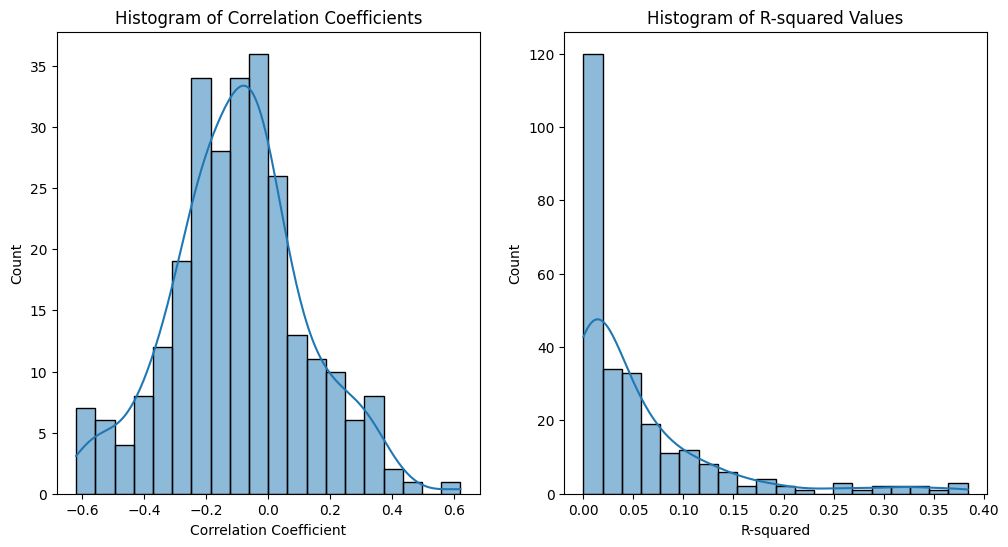

In [18]:
# Histogram of Correlation Coefficients
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(correlation_results['Correlation Coefficient'], bins=20, kde=True)
plt.title('Histogram of Correlation Coefficients')

# Histogram of R-squared values
plt.subplot(1, 2, 2)
sns.histplot(regression_results['R-squared'], bins=20, kde=True)
plt.title('Histogram of R-squared Values')
plt.show()

## Histogram of Correlation Coefficients
- There is not a strong uniform positive or negative linear relationship between Internet Penetration Rate and GDP Growth across all countries.
- The symmetry suggests that there are as many countries with a positive relationship as there are with a negative relationship between the two variables.
- The spread of the correlation coefficients implies varying strengths of relationships across different countries, with some countries exhibiting a stronger relationship (either positive or negative) than others.

## Histogram of R-squared Values
- The R-squared values are skewed towards the lower end, suggesting that for most countries, the Internet Penetration Rate does not explain a large portion of the variance in GDP Growth.
- The concentration of R-squared values close to zero suggests that the linear model does not fit the data well for most countries—meaning the Internet Penetration Rate alone may not be a strong predictor of GDP Growth in those cases.

# Analysis of Countries With Statistically Significant Relationships

In [19]:
significant_countries = regression_results[regression_results['P-value'] < 0.05]['Country']

/var/folders/8g/91mbqbq14mn8p3xpyyfy4bqm0000gn/T/ipykernel_97006/3943978902.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


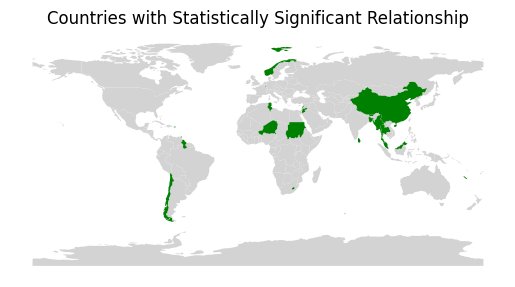

In [20]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

significant_countries_df = pd.DataFrame(significant_countries, columns=['Country'])
world_significant = world.merge(significant_countries_df, left_on='name', right_on='Country', how='left')

non_significant_color = 'lightgrey'
significant_color = 'green'

ax = world[~world['name'].isin(significant_countries)].plot(color=non_significant_color)
world[world['name'].isin(significant_countries)].plot(ax=ax, color=significant_color)

ax.set_axis_off()
plt.title('Countries with Statistically Significant Relationship')

plt.show()


Most of them are developing countries, but Norway can be considered as a special case.
This result is obvious as developing countries tend to have a more rapid economic growth than developed countries, together with greater access to the Internet year by year.

# Clustering Analysis for the Countries to Provide a Better Insight

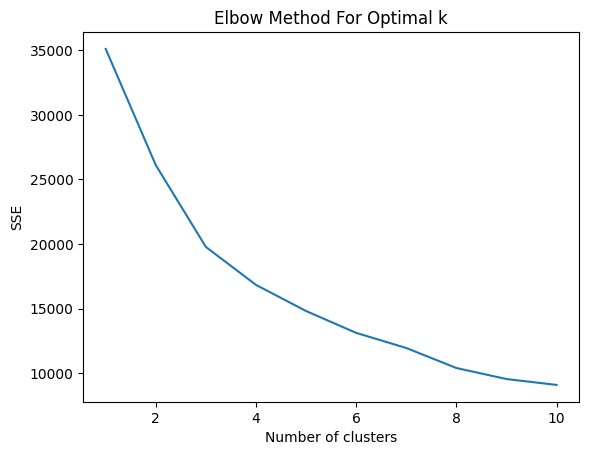

In [22]:
df_merged_with_corr = pd.merge(df_merged, correlation_results, left_on='Country Name', right_on='Country', how='left')
df_merged_with_corr_reg = pd.merge(df_merged_with_corr, regression_results, left_on='Country Name', right_on='Country', how='left')

features = df_merged_with_corr_reg[['Internet Penetration Rate', 'GDP Growth', 'Correlation Coefficient', 'R-squared']].copy()
features.dropna(inplace=True)

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=21).fit(features_scaled)
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.title("Elbow Method For Optimal k")
plt.show()


In [23]:
kmeans = KMeans(n_clusters=4, random_state=21)
clusters = kmeans.fit_predict(features_scaled)
df_merged_with_corr_reg['Cluster'] = clusters


In [24]:
for k in sorted(df_merged_with_corr_reg['Cluster'].unique()):
    cluster_data = df_merged_with_corr_reg[df_merged_with_corr_reg['Cluster'] == k]
    print(f"Cluster {k} Summary Statistics:")
    print(cluster_data[['Internet Penetration Rate', 'GDP Growth', 'Correlation Coefficient', 'R-squared']].describe())
    print("\n")

Cluster 0 Summary Statistics:
       Internet Penetration Rate   GDP Growth  Correlation Coefficient  \
count                1010.000000  1010.000000              1010.000000   
mean                   24.865968     5.145733                -0.460696   
std                    28.899058     7.782464                 0.091216   
min                     0.000002   -21.399900                -0.618555   
25%                     0.418663     2.299048                -0.551792   
50%                    11.624045     4.647133                -0.435025   
75%                    42.812878     7.099206                -0.377651   
max                   100.000000   149.972963                -0.296480   

         R-squared  
count  1010.000000  
mean      0.220553  
std       0.086174  
min       0.087900  
25%       0.142620  
50%       0.189246  
75%       0.304475  
max       0.382611  


Cluster 1 Summary Statistics:
       Internet Penetration Rate   GDP Growth  Correlation Coefficient  \
count   

**Cluster 0**

- Characteristics: Lower internet penetration (mean: 24.87%) but relatively higher GDP growth (mean: 5.15%). This cluster has a notably negative correlation between Internet Penetration and GDP growth (mean: -0.46), suggesting that in these countries, higher internet rates might coincide with lower GDP growth rates, although the relationship is moderately strong (mean R-squared: 0.22).
- Implications: Countries in this cluster might be in earlier stages of internet adoption or may have other strong economic growth drivers independent of internet penetration.

**Cluster 1**

- Characteristics: High internet penetration (mean: 67.84%) with modest GDP growth (mean: 1.88%). The correlation coefficient is close to zero (mean: -0.11), indicating a very weak or no linear relationship between internet penetration and GDP growth, which is supported by a low R-squared (mean: 0.033).
- Implications: This cluster likely includes developed countries where high internet penetration has minimal incremental impact on GDP growth, possibly due to the saturation of internet access.

**Cluster 2**

- Characteristics: Moderate internet penetration (mean: 16.20%) with relatively low GDP growth (mean: 2.55%). The correlation is positively moderate (mean: 0.28), suggesting that in these countries, increases in internet penetration could be associated with increases in GDP growth (mean R-squared: 0.09).
- Implications: Emerging markets where further development in internet infrastructure might stimulate economic growth.

**Cluster 3**

- Characteristics: Very low internet penetration (mean: 7.64%) with moderate GDP growth (mean: 3.69%). The correlation is slightly negative (mean: -0.09) with a very low R-squared (mean: 0.021), indicating a weak relationship between internet penetration and GDP growth.
- Implications: These might be developing countries where other factors than internet penetration are stronger drivers of GDP growth, or countries where the potential for growth through internet penetration remains largely untapped.

In [25]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.merge(
    df_merged_with_corr_reg, left_on="iso_a3", right_on="Country Code", how="left"
)
world["Cluster"] = pd.Categorical(world["Cluster"], categories=[0, 1, 2, 3])

/var/folders/8g/91mbqbq14mn8p3xpyyfy4bqm0000gn/T/ipykernel_97006/2716268284.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


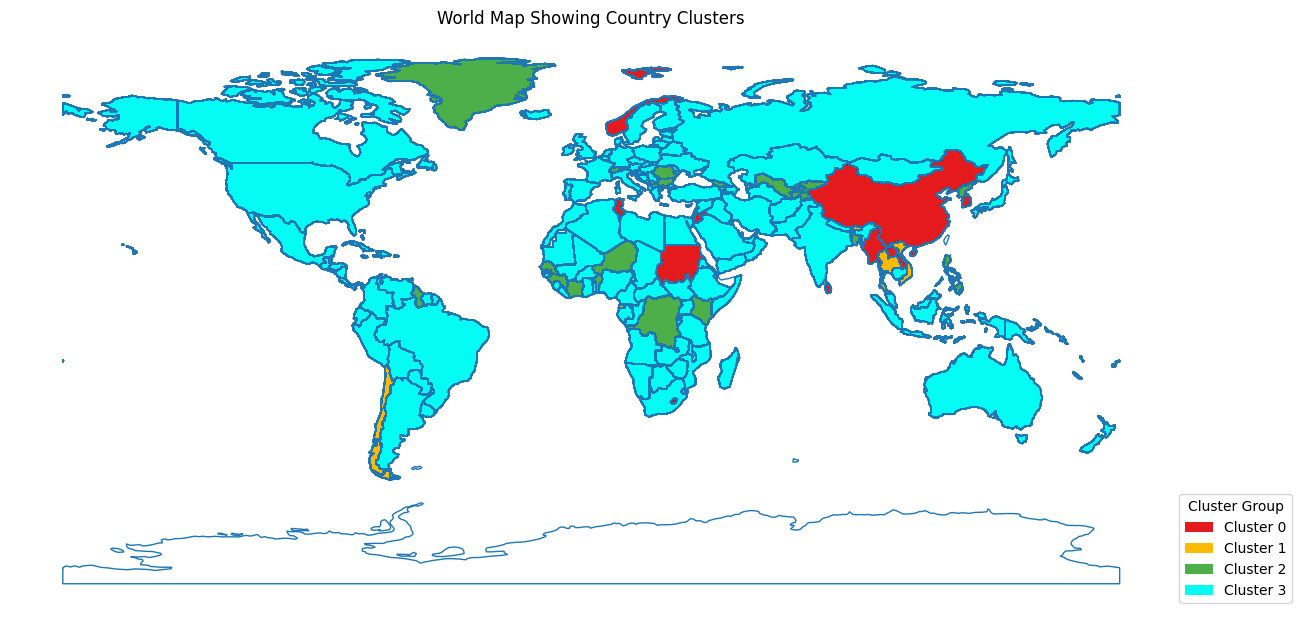

In [26]:
cluster_colors = {0: '#e41a1c', 1: '#fcba03', 2: '#4daf4a', 3: '#03fcf4'}

fig, ax = plt.subplots(1, figsize=(15, 10))
world.boundary.plot(ax=ax, linewidth=1)
for cluster, color in cluster_colors.items():
    world[world['Cluster'] == cluster].plot(color=color, ax=ax, label=f'Cluster {cluster}')
from matplotlib.patches import Patch
legend_labels = [Patch(facecolor=color, label=f'Cluster {label}') for label, color in cluster_colors.items()]
ax.legend(handles=legend_labels, loc='lower left', bbox_to_anchor=(1, 0), title="Cluster Group")
ax.set_axis_off()

plt.title("World Map Showing Country Clusters")
plt.show()


# Conclusions
- Internet penetration is a significant factor, it's clear from the analysis that it alone does not dictate GDP growth trends across all contexts. The relationship varies among different clusters of countries, indicating that other economic, social, and infrastructural factors also play critical roles in shaping economic outcomes.
- While increased internet access can be a catalyst for economic growth, especially in emerging markets, it should be considered alongside a broader array of developmental strategies.